In [43]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Importing packages
from fastai.vision import *
from fastai.metrics import error_rate
import os
from PIL import Image, ImageChops, ImageEnhance
import gc
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import pickle
import pretrainedmodels
from torchvision.models import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta

from utils import *
import sys
gc.collect()

36

In [44]:
torch.cuda.is_available()
# torch.cuda.set_device(0)

In [45]:
# path = '/home/ubuntu/Documents/ELA/'
path = '/home/ubuntu/share/stage-3/stage3_image_data/'

In [98]:
# Helper functions

def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

def convert_to_ela_image(path, folder, quality):
    filename = path
    ela_filename = f'/home/ubuntu/Documents/ELA2/{folder}/'
    resaved_filename = '/home/ubuntu/Documents/temp.jpg'
    
    fname = filename.split('/')[-1]
    ela_filename = ela_filename + fname
    if(os.path.isfile(ela_filename)):
        return
#     print(ela_filename)
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    ela_im = ela_im.resize((512, 512))
    ela_im.save(ela_filename)
    
    return ela_im

# Generate/Save ELA files for the train/test images.
def generate_ela_files(files, is_train = False, labels = None):
    if(is_train):
        for f,l in tqdm(zip(files, labels)):
            convert_to_ela_image(f,f'train/{l}', 90)
    else:
        print(len(files))
        for f in tqdm(files):
#             print(f)
            convert_to_ela_image(f, 'train/fake', 90)
    
# Getting balanced set for train/validation
def get_balanced_data(l_real, l_fake):
    l_fake_sampled = np.random.choice(l_fake, len(l_real), replace = False)
    files = l_real + list(l_fake_sampled)
    labels = ['real']*len(l_real) + ['fake']*len(l_fake_sampled)
    assert(len(files) == len(labels))
    return files,labels

def get_predictions(learn, is_test = False):
    if(is_test):
        log_preds = learn.predict(is_test)
        preds = np.argmax(log_preds, axis=1)
        probs = np.exp(log_preds)
    else:
        log_preds, y = learn.TTA()
        probs = np.mean(np.exp(log_preds),0)
        print(accuracy_np(probs,y))
        preds = np.argmax(probs, axis=1)  # from log probabilities to 0 or 1ts
        from sklearn.metrics import f1_score
        print('F1_score: ', f1_score(y,preds,average='weighted'))
        
def get_metrics(y, preds):
    from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
    print('F1_score: ', f1_score(y,preds,average='weighted'))
    print('Accuracy: ', accuracy_score(y,preds))
    print(confusion_matrix(y,preds))
    
def get_files(l_real, l_fake):
    files = [path+'/'.join(x.split('/')[-3:]) for x in l_real] + [path+'/'.join(x.split('/')[-3:]) for x in l_fake]
    labels = ['real']*len(l_real) + ['fake']*len(l_fake)
    return files, labels

def xception(pretrained=True):
    pretrained = 'imagenet+background' if pretrained else None
    model = pretrainedmodels.__dict__['xception'](pretrained=pretrained)
    return nn.Sequential(*list(model.children()))

def get_learner(model_name, data):
    if('resnet' in model_name):
        m = eval(model_name)
        learn = create_cnn(data, m, metrics=accuracy)
        return learn
    else:
        if('densenet' in model_name):
            m = eval(model_name)
            learn = create_cnn(data, m, pretrained=True, cut=-1, split_on=lambda m: (m[0][0][7],m[1]), metrics = accuracy)
            return learn
        elif(model_name == 'inceptionv4'):
            learn = create_cnn(FakeData(), inceptionv4, pretrained=True, cut=-2, split_on=lambda m: (m[0][11], m[1]))
        elif(model_name == 'xception'):
            learn = create_cnn(data, xception, pretrained=True, cut = -1, split_on = lambda m: (m[0][11], m[1]))
    return learn

# Create 3 different balanced train sets 
## Each having same set of real images(7K) and diff fake ones (7K)
## Remaining files are kept as holdout validation set
def generate_multi_version():
    path_n = '/home/ubuntu/share/stage-3/stage3_image_data/'
    l_real = get_imlist(f'{path_n}train/real')
    l_fake = get_imlist(f'{path_n}train/fake')
    import random
    random.seed(42)
    random.shuffle(l_real)
    random.shuffle(l_fake)
    train_real = l_real[:7000]
    train_fake1 = l_fake[:7000]
    train_fake2 = l_fake[7000:14000]
    train_fake3 = l_fake[14000:21000]
    val_fake = l_fake[21000:]
    val_real = l_real[7000:]
    train_label = ['real']*len(train_real) + ['fake']*len(train_fake1)
    val_label = ['real']*len(val_real) + ['fake']*len(val_fake)
    
    train_files1 = train_real + train_fake1
    train_files2 = train_real + train_fake2
    train_files3 = train_real + train_fake3
    val_files = val_real + val_fake
    
    
    return [train_files1, train_files2, train_files3], train_label, val_files, val_label
   

In [64]:
l_real = get_imlist(f'{path}train/real')
l_fake = get_imlist(f'{path}train/fake')
test_files = get_imlist(f'{path}test/test')

In [65]:
len(l_real), len(l_fake), len(test_files)

(8373, 23887, 5430)

In [ ]:
files = l_real + l_fake
labels = ['real']*len(l_real) + ['fake']*len(l_fake)

In [51]:
generate_ela_files(files, True, labels)

16746it [54:01,  5.17it/s]


In [68]:
generate_ela_files(test_files)

100%|██████████| 5430/5430 [22:28<00:00,  4.03it/s]  


In [8]:
# files,labels = get_files(l_real,l_fake)

In [9]:
# files_df = pd.DataFrame({'Files': files, 'labels': labels})

In [99]:
train_files_all, train_label, val_files, val_label = generate_multi_version()

In [103]:
# Few sanity checks
print(len(train_files_all[0]), len(train_files_all[1]), len(train_files_all[2]))
print(len(train_label), np.unique(train_label, return_counts = True))
print(len(val_files), len(val_label), np.unique(val_label, return_counts = True))

14000 14000 14000
14000 (array(['fake', 'real'], dtype='<U4'), array([7000, 7000]))
4260 4260 (array(['fake', 'real'], dtype='<U4'), array([2887, 1373]))


In [ ]:
# files = ['/home/ubuntu/Documents/ELA/' + '/'.join(x.split('/')[-3:]) for x in files]

In [15]:
for i in range(3):
    train_files_all[i] = ['/home/ubuntu/Documents/ELA2/' + '/'.join(x.split('/')[-3:]) for x in train_files_all[i]]
val_files = ['/home/ubuntu/Documents/ELA2/' + '/'.join(x.split('/')[-3:]) for x in val_files]

In [ ]:
# Approach
## The aim was to get similar acc on all the 3 balanced set created at start - an indicator of model generalizing well on unseen data
#### This decision was based on the observation that we had very diff val accuracies on diff samples of 'fake' used as train 
## Experimented on side to reach a final set of hp which seemed to give similar acc on all 3 val splits for respective train sets

## Proceeded with progressive resizing to improve val acc further.

## Entire above exercise was done on ELA images as well normal images.
## Final submission ensemble of two. - this gave a good lift in f1

In [17]:
# 1st iter model on size 128
files, labels = train_files_all[0], train_label
path = 'home/ubuntu/Documents/ELA2/'
fname2label = {f:l for (f,l) in zip(files, labels)}
src = ImageItemList(files, path=path).random_split_by_pct(valid_pct=0.25, seed=42).label_from_func(lambda x:fname2label[x])
# Removing cropping as default transformation
tfms = get_transforms()
tfms = (tfms[0][1:],[])
data = ImageDataBunch.create_from_ll(src, size = 128, test = 'test', bs = 64, ds_tfms = tfms)
learn = create_cnn(data, resnet34, pretrained=True, metrics = accuracy)
learn.load('/home/ubuntu/Documents/ELA/models/prsz_299_freezed_ela_iter22')
learn.fit_one_cycle(4)
learn.save('ela2_prsz_128_frz_set0')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(1e-5,1e-4))
learn.fit_one_cycle(2, max_lr = slice(5e-6,1e-5))
learn.save('ela2_prsz_128_unfrz_set0')


epoch,train_loss,valid_loss,accuracy
1,0.556275,0.522364,0.747429
2,0.533718,0.514938,0.752286
3,0.523318,0.509010,0.751143
4,0.524286,0.507834,0.756000


epoch,train_loss,valid_loss,accuracy
1,0.519596,0.501937,0.763714
2,0.506621,0.498971,0.758857


epoch,train_loss,valid_loss,accuracy
1,0.508699,0.496347,0.763143
2,0.506963,0.496946,0.760000


In [31]:
#2nd iter model on size 128
files, labels = train_files_all[1], train_label
path = 'home/ubuntu/Documents/ELA2/'
fname2label = {f:l for (f,l) in zip(files, labels)}
src = ImageItemList(files, path=path).random_split_by_pct(valid_pct=0.25, seed=42).label_from_func(lambda x:fname2label[x])
tfms = get_transforms()
tfms = (tfms[0][1:],[])
data = ImageDataBunch.create_from_ll(src, size = 128, test = 'test', bs = 64, ds_tfms = tfms)
learn = create_cnn(data, resnet34, pretrained=True, metrics = accuracy)
learn.load('ela2_prsz_128_unfrz_set0')
learn.fit_one_cycle(4)
learn.save('ela2_prsz_128_frz_set1')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(1e-5,1e-4))
learn.fit_one_cycle(2, max_lr = slice(5e-6,1e-5))
learn.save('ela2_prsz_128_unfrz_set1')


epoch,train_loss,valid_loss,accuracy
1,0.513156,0.507871,0.759143
2,0.518863,0.507453,0.758857
3,0.517992,0.505678,0.758857
4,0.502330,0.505530,0.759714


epoch,train_loss,valid_loss,accuracy
1,0.503629,0.503987,0.757714
2,0.500678,0.503320,0.755429


epoch,train_loss,valid_loss,accuracy
1,0.495593,0.504584,0.757429
2,0.496892,0.503236,0.760286


In [32]:
# 3rd iter model on size 128
files, labels = train_files_all[2], train_label
path = 'home/ubuntu/Documents/ELA2/'
fname2label = {f:l for (f,l) in zip(files, labels)}
src = ImageItemList(files, path=path).random_split_by_pct(valid_pct=0.25, seed=42).label_from_func(lambda x:fname2label[x])
tfms = get_transforms()
tfms = (tfms[0][1:],[])
data = ImageDataBunch.create_from_ll(src, size = 128, test = 'test', bs = 64, ds_tfms = tfms)
learn = create_cnn(data, resnet34, pretrained=True, metrics = accuracy)
learn.load('ela2_prsz_128_unfrz_set1')
learn.fit_one_cycle(4)
learn.save('ela2_prsz_128_frz_set2')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(1e-5,1e-4))
learn.fit_one_cycle(2, max_lr = slice(5e-6,1e-5))
learn.save('ela2_prsz_128_unfrz_set2')


epoch,train_loss,valid_loss,accuracy
1,0.501382,0.503782,0.759143
2,0.497225,0.500694,0.759714
3,0.489146,0.501273,0.756857
4,0.488903,0.501094,0.759143


epoch,train_loss,valid_loss,accuracy
1,0.498618,0.499787,0.760571
2,0.487119,0.500565,0.762000


epoch,train_loss,valid_loss,accuracy
1,0.475199,0.503268,0.762286
2,0.481139,0.502274,0.764000


In [33]:
# 1st iter model on size 224
files, labels = train_files_all[0], train_label
path = 'home/ubuntu/Documents/ELA2/'
fname2label = {f:l for (f,l) in zip(files, labels)}
src = ImageItemList(files, path=path).random_split_by_pct(valid_pct=0.25, seed=42).label_from_func(lambda x:fname2label[x])
tfms = get_transforms()
tfms = (tfms[0][1:],[])
data = ImageDataBunch.create_from_ll(src, size = 224, test = 'test', bs = 64, ds_tfms = tfms)
learn = create_cnn(data, resnet34, pretrained=True, metrics = accuracy)
learn.load('ela2_prsz_128_unfrz_set2')
learn.fit_one_cycle(4)
learn.save('ela2_prsz_224_frz_set0')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(1e-5,1e-4))
learn.fit_one_cycle(2, max_lr = slice(5e-6,1e-5))
learn.save('ela2_prsz_224_unfrz_set0')


epoch,train_loss,valid_loss,accuracy
1,0.485350,0.524085,0.754000
2,0.484521,0.503620,0.754000
3,0.480798,0.502310,0.764857
4,0.469499,0.494159,0.769429


epoch,train_loss,valid_loss,accuracy
1,0.465912,0.495280,0.766286
2,0.466468,0.488342,0.773429


epoch,train_loss,valid_loss,accuracy
1,0.464466,0.502645,0.762286
2,0.468186,0.498425,0.765143


In [34]:
# 2nd iter model on size 224
files, labels = train_files_all[1], train_label
path = 'home/ubuntu/Documents/ELA2/'
fname2label = {f:l for (f,l) in zip(files, labels)}
src = ImageItemList(files, path=path).random_split_by_pct(valid_pct=0.25, seed=42).label_from_func(lambda x:fname2label[x])
tfms = get_transforms()
tfms = (tfms[0][1:],[])
data = ImageDataBunch.create_from_ll(src, size = 224, test = 'test', bs = 64, ds_tfms = tfms)
learn = create_cnn(data, resnet34, pretrained=True, metrics = accuracy)
learn.load('ela2_prsz_224_unfrz_set0')
learn.fit_one_cycle(4)
learn.save('ela2_prsz_224_frz_set1')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(1e-5,1e-4))
learn.fit_one_cycle(2, max_lr = slice(5e-6,1e-5))
learn.save('ela2_prsz_224_unfrz_set1')


epoch,train_loss,valid_loss,accuracy
1,0.478043,0.492816,0.758286
2,0.480025,0.497928,0.753143
3,0.469031,0.486419,0.760571
4,0.460763,0.497334,0.752286


epoch,train_loss,valid_loss,accuracy
1,0.476757,0.488769,0.760286
2,0.458073,0.489804,0.761143


epoch,train_loss,valid_loss,accuracy
1,0.461036,0.490110,0.758571
2,0.459241,0.482985,0.764571


In [35]:
# 3rd iter model on size 224
files, labels = train_files_all[2], train_label
path = 'home/ubuntu/Documents/ELA2/'
fname2label = {f:l for (f,l) in zip(files, labels)}
src = ImageItemList(files, path=path).random_split_by_pct(valid_pct=0.25, seed=42).label_from_func(lambda x:fname2label[x])
tfms = get_transforms()
tfms = (tfms[0][1:],[])
data = ImageDataBunch.create_from_ll(src, size = 224, test = 'test', bs = 64, ds_tfms = tfms)
learn = create_cnn(data, resnet34, pretrained=True, metrics = accuracy)
learn.load('ela2_prsz_224_unfrz_set1')
learn.fit_one_cycle(4)
learn.save('ela2_prsz_224_frz_set2')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(1e-5,1e-4))
learn.fit_one_cycle(2, max_lr = slice(5e-6,1e-5))
learn.save('ela2_prsz_224_unfrz_set2')


epoch,train_loss,valid_loss,accuracy
1,0.458445,0.495060,0.770857
2,0.457484,0.482811,0.770571
3,0.451893,0.500084,0.760857
4,0.448551,0.487775,0.769429


epoch,train_loss,valid_loss,accuracy
1,0.463320,0.483189,0.773714
2,0.444985,0.482079,0.771429


epoch,train_loss,valid_loss,accuracy
1,0.448058,0.480700,0.772857
2,0.445798,0.483240,0.771143


In [36]:
# 1st iter model on size 299
files, labels = train_files_all[0], train_label
path = 'home/ubuntu/Documents/ELA2/'
fname2label = {f:l for (f,l) in zip(files, labels)}
src = ImageItemList(files, path=path).random_split_by_pct(valid_pct=0.25, seed=42).label_from_func(lambda x:fname2label[x])
tfms = get_transforms()
tfms = (tfms[0][1:],[])
data = ImageDataBunch.create_from_ll(src, size = 299, test = 'test', bs = 64, ds_tfms = tfms)
learn = create_cnn(data, resnet34, pretrained=True, metrics = accuracy)
learn.load('ela2_prsz_224_unfrz_set2')
learn.fit_one_cycle(4)
learn.save('ela2_prsz_299_frz_set0')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(1e-5,1e-4))
learn.fit_one_cycle(2, max_lr = slice(5e-6,1e-5))
learn.save('ela2_prsz_299_unfrz_set0')


epoch,train_loss,valid_loss,accuracy
1,0.456077,0.469530,0.782571
2,0.460838,0.467895,0.782857
3,0.459286,0.464442,0.785143
4,0.442363,0.465460,0.783429


epoch,train_loss,valid_loss,accuracy
1,0.460074,0.470524,0.780286
2,0.448075,0.467222,0.783429


epoch,train_loss,valid_loss,accuracy
1,0.424523,0.465925,0.785429
2,0.439334,0.467333,0.784571


In [37]:
# 2nd iter model on size 299
files, labels = train_files_all[1], train_label
path = 'home/ubuntu/Documents/ELA2/'
fname2label = {f:l for (f,l) in zip(files, labels)}
src = ImageItemList(files, path=path).random_split_by_pct(valid_pct=0.25, seed=42).label_from_func(lambda x:fname2label[x])
tfms = get_transforms()
tfms = (tfms[0][1:],[])
data = ImageDataBunch.create_from_ll(src, size = 299, test = 'test', bs = 64, ds_tfms = tfms)
learn = create_cnn(data, resnet34, pretrained=True, metrics = accuracy)
learn.load('ela2_prsz_299_unfrz_set0')
learn.fit_one_cycle(4)
learn.save('ela2_prsz_299_frz_set1')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(1e-5,1e-4))
learn.fit_one_cycle(2, max_lr = slice(5e-6,1e-5))
learn.save('ela2_prsz_299_unfrz_set1')


epoch,train_loss,valid_loss,accuracy
1,0.454746,0.471391,0.775143
2,0.442271,0.470967,0.778857
3,0.441257,0.470947,0.778286
4,0.439012,0.471762,0.780857


epoch,train_loss,valid_loss,accuracy
1,0.452828,0.487525,0.765429
2,0.426538,0.473686,0.777143


epoch,train_loss,valid_loss,accuracy
1,0.431918,0.478344,0.776571
2,0.417714,0.476806,0.777429


In [38]:
# 3rd iter model on size 299
files, labels = train_files_all[2], train_label
path = 'home/ubuntu/Documents/ELA2/'
fname2label = {f:l for (f,l) in zip(files, labels)}
src = ImageItemList(files, path=path).random_split_by_pct(valid_pct=0.25, seed=42).label_from_func(lambda x:fname2label[x])
tfms = get_transforms()
tfms = (tfms[0][1:],[])
data = ImageDataBunch.create_from_ll(src, size = 299, test = 'test', bs = 64, ds_tfms = tfms)
learn = create_cnn(data, resnet34, pretrained=True, metrics = accuracy)
learn.load('ela2_prsz_299_unfrz_set1')
learn.fit_one_cycle(4)
learn.save('ela2_prsz_299_frz_set2')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(1e-5,1e-4))
learn.fit_one_cycle(2, max_lr = slice(5e-6,1e-5))
learn.save('ela2_prsz_299_unfrz_set2')


epoch,train_loss,valid_loss,accuracy
1,0.430627,0.480224,0.775429
2,0.440238,0.477205,0.778857
3,0.430465,0.478991,0.779714
4,0.425552,0.477765,0.778857


epoch,train_loss,valid_loss,accuracy
1,0.436265,0.476740,0.781143
2,0.415353,0.475092,0.782000


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f26c8dd57f0>>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f26c8dd57f0>>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/u

epoch,train_loss,valid_loss,accuracy
1,0.407751,0.475758,0.777714
2,0.406571,0.476755,0.779429


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f26c8dd57f0>>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f26c8dd57f0>>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/u

In [91]:
# Test on the holdout validation set.
fname2label = {f:l for (f,l) in zip(val_files, val_label)}
src = ImageItemList(val_files, path=path).random_split_by_pct(valid_pct=0.99, seed=42).label_from_func(lambda x:fname2label[x])
tfms = get_transforms()
tfms = (tfms[0][1:],[])
data = ImageDataBunch.create_from_ll(src, size = 299, bs = 64, ds_tfms = tfms)

You can deactivate this warning by passing `no_check=True`.


/opt/anaconda3/lib/python3.6/site-packages/fastai/basic_data.py:211: UserWarning: Your training dataloader is empty, you have only 43 items in your training set.
                 Your batch size is 64, you should lower it.
  Your batch size is {self.train_dl.batch_size}, you should lower it.""")


In [92]:
learn = create_cnn(data, resnet34, pretrained=True, metrics = accuracy)
learn.load('/home/ubuntu/home/ubuntu/Documents/ELA2/models/ela2_prsz_299_unfrz_set2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (43 items)
[Category real, Category real, Category real, Category real, Category real]...
Path: /home/ubuntu/Documents/ELA
x: ImageItemList (43 items)
[Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224)]...
Path: /home/ubuntu/Documents/ELA;

Valid: LabelList
y: CategoryList (4217 items)
[Category fake, Category fake, Category fake, Category fake, Category fake]...
Path: /home/ubuntu/Documents/ELA
x: ImageItemList (4217 items)
[Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224), Image (3, 224, 224)]...
Path: /home/ubuntu/Documents/ELA;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation

In [93]:
np.unique(learn.data.valid_ds.y.items, return_counts = True)

(array([0, 1]), array([2858, 1359]))

In [94]:
p = learn.get_preds()

In [95]:
temp = np.argmax(p[0], axis = 1)
get_metrics(data.valid_ds.y.items, temp)

F1_score:  0.7638183946703178
Accuracy:  0.7562248043632914
[[2063  795]
 [ 233 1126]]


In [131]:
def get_data_for_ela_1(modelname):
    fname2label = {f:l for (f,l) in zip(val_files, val_label)}
    path = '/home/ubuntu/Documents/ELA/'
    src = ImageItemList(val_files, path=path).random_split_by_pct(valid_pct=0.99, seed=42).label_from_func(lambda x:fname2label[x])
    tfms = get_transforms()
    tfms = (tfms[0][1:],[])
    data = ImageDataBunch.create_from_ll(src, size = 299, bs = 64, test = 'test', ds_tfms = tfms)
    learn = create_cnn(data, resnet34, pretrained=True, metrics = accuracy)
    learn.load(f'/home/ubuntu/home/ubuntu/Documents/ELA2/models/{modelname}')
    print(np.unique(learn.data.valid_ds.y.items, return_counts = True))
    learn.data.test_dl.items.sort()
    print(len(learn.data.test_ds.items))
    print(learn.data.test_dl.x.items[8])
    return learn

def get_normal_data(modelname):
    path = '/home/ubuntu/share/stage-3/stage3_image_data/'
    val_files_1 = ['/home/ubuntu/share/stage-3/stage3_image_data/' + '/'.join(x.split('/')[-3:]) for x in val_files]
    fname2label = {f:l for (f,l) in zip(val_files_1, val_label)}
    src = ImageItemList(val_files_1, path=path).random_split_by_pct(valid_pct=0.99, seed=42).label_from_func(lambda x:fname2label[x])
    tfms = get_transforms()
    tfms = (tfms[0][1:],[])
    data = ImageDataBunch.create_from_ll(src, size = 224, bs = 64, ds_tfms = tfms, test = 'test')
    data.path = '/home/ubuntu/Documents/'
    learn = create_cnn(data, resnet50, pretrained=True, metrics = accuracy)
    print(np.unique(learn.data.valid_ds.y.items, return_counts = True))
    learn.data.test_dl.items.sort()
    print(len(learn.data.test_ds.items))
    print(learn.data.test_dl.x.items[8])
    learn.load(f'/home/ubuntu/Documents/models/{modelname}')
    return learn

In [117]:
net_dict = {'resnet18': models.resnet18, 'resnet34': models.resnet34, 'resnet50': models.resnet50, 'resnet101': models.resnet101}
models_used_def = ['ela2_prsz_299_unfrz_set2','resnet50_trns_iter_2']
def get_ensemble(models_used = models_used_def, is_test = False):
    models_combined = pd.DataFrame()
    all_res = {}
    for i in models_used:
        print(i)
        netname = i.split('_')[0]
#         arch = net_dict[netname]
        if('ela' in i):
            # need to load data from ela folder
            learn = get_data_for_ela_1(i)
        else:
            learn = get_normal_data(i)
        if(is_test):
            d = DatasetType.Test
        else:
            d = DatasetType.Valid
        probs = learn.get_preds(d)
        all_res[i] = np.argmax(probs[0], axis = 1)
        all_res[i+'fake'] = [float(x[0]) for x in probs[0]]
        all_res[i+'real'] = [float(x[1]) for x in probs[0]]
        if(is_test == False):
            get_metrics(data.valid_ds.y.items, all_res[i])
        all_res[i+'|prob'] = np.max(np.array(probs[0]), axis = 1)
    models_combined = pd.DataFrame(all_res)
    return models_combined

def get_ensemble_submission(is_t = False):
    results_combined = get_ensemble(is_test = is_t)
    results_combined['confident'] = results_combined[[x+'|prob' for x in models_used_def]].idxmax(axis = 1)
    results_combined['label'] = results_combined.apply(lambda x : x[x['confident'].split('|')[0]], axis = 1)
    return results_combined['label'].astype(int).values

def get_submission_file(learn, ensemble = True, output_filename = 'final_submission.csv'):
    if(ensemble):
        test_preds = get_ensemble_submission(True)
    else:
        test_predictions = learn.predict(is_test = True)
        test_preds = np.argmax(test_predictions, axis=1)  # from log probabilities to 0 or 1ts
        test_probs = np.exp(test_predictions[:,1])        # pr()
        
    labels = [data.classes[x] for x in test_preds]
    assert(len(data.test_dl.x.items) == len(labels))
    
    output_df = pd.DataFrame({'Filename':data.test_dl.x.items, 'Prediction': np.array(labels)})
    output_df['Filename'] = output_df['Filename'].apply(lambda x: str(x).split('/')[-1])
    
    output_df.to_csv(output_filename, index=False)
    return output_df



In [1]:
# dela = get_data_for_ela_1()
# len(dela.test_ds.y.items)

In [118]:
comb = get_ensemble(is_test = False)

F1_score:  0.7572649556377495
Accuracy:  0.7491107422338155
[[1993  865]
 [ 193 1166]]


In [133]:
comb['confident'] = comb[[x+'|prob' for x in models_used_def]].idxmax(axis = 1)

In [134]:
comb['label'] = comb.apply(lambda x : x[x['confident'].split('|')[0]], axis = 1)

In [121]:
# Ensemble result on holdout val set
get_metrics(data.valid_ds.y.items, comb.label.values)

F1_score:  0.8205281496603728
Accuracy:  0.8152715200379417
[[2241  617]
 [ 162 1197]]


In [ ]:
# Getting the prediction on the test set

In [132]:
comb = get_ensemble(is_test = True)

In [133]:
comb['confident'] = comb[[x+'|prob' for x in models_used_def]].idxmax(axis = 1)

In [134]:
comb['label'] = comb.apply(lambda x : x[x['confident'].split('|')[0]], axis = 1)

In [135]:
comb.head()

,ela2_prsz_299_unfrz_set2,ela2_prsz_299_unfrz_set2fake,ela2_prsz_299_unfrz_set2real,ela2_prsz_299_unfrz_set2|prob,resnet50_trns_iter_2,resnet50_trns_iter_2fake,resnet50_trns_iter_2real,resnet50_trns_iter_2|prob,confident,label
0,1,0.294935,0.705065,0.705065,1,0.410452,0.589548,0.589548,ela2_prsz_299_unfrz_set2|prob,1
1,0,0.883732,0.116267,0.883732,0,0.510377,0.489623,0.510377,ela2_prsz_299_unfrz_set2|prob,0
2,0,0.973347,0.026653,0.973347,0,0.934513,0.065487,0.934513,ela2_prsz_299_unfrz_set2|prob,0
3,0,0.585824,0.414176,0.585824,0,0.826101,0.173899,0.826101,resnet50_trns_iter_2|prob,0
4,1,0.451896,0.548104,0.548104,1,0.145631,0.854369,0.854369,resnet50_trns_iter_2|prob,1


In [137]:
la = comb['label'].astype(int).values
lals = [data.classes[x] for x in la]
assert(len(data.test_dl.x.items) == len(lals))

output_df = pd.DataFrame({'Filename':data.test_dl.x.items, 'Prediction': np.array(lals)})
output_df['Filename'] = output_df['Filename'].apply(lambda x: str(x).split('/')[-1])

output_df.to_csv('submission_ensemble_final.csv', index=False)

In [138]:
output_df.Prediction.value_counts()

real    2752
fake    2678
Name: Prediction, dtype: int64

In [63]:
comb.head()

,resnet50_trns_iter_2,resnet50_trns_iter_2fake,resnet50_trns_iter_2real,resnet50_trns_iter_2|prob,resnet34_ela_299_iter22,resnet34_ela_299_iter22fake,resnet34_ela_299_iter22real,resnet34_ela_299_iter22|prob,confident,label
0,1,0.055228,0.944772,0.944772,1,0.416043,0.583957,0.583957,resnet50_trns_iter_2|prob,1
1,1,0.206869,0.793131,0.793131,1,0.497745,0.502255,0.502255,resnet50_trns_iter_2|prob,1
2,1,0.318592,0.681408,0.681408,1,0.322339,0.677661,0.677661,resnet50_trns_iter_2|prob,1
3,0,0.656912,0.343088,0.656912,1,0.429506,0.570494,0.570494,resnet50_trns_iter_2|prob,0
4,0,0.753644,0.246356,0.753644,1,0.450236,0.549764,0.549764,resnet50_trns_iter_2|prob,0


# Rough, no need to refer

In [32]:
# learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [33]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy
1,0.710183,0.618685,0.656235
2,0.622221,0.594685,0.688485
3,0.578733,0.576262,0.695891
4,0.548707,0.567682,0.709986


In [34]:
learn.save('resnet50_trns_iter1')

In [35]:
learn.freeze_to(-2)

In [36]:
learn.data.batch_size = 32

In [37]:
learn.fit_one_cycle(2, max_lr = slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.548446,0.555912,0.711897
2,0.484806,0.546715,0.725036


In [38]:
learn.save('resnet50_trns_iter_2')

In [59]:
learn.fit_one_cycle(2, max_lr = slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.448832,0.555732,0.726708
2,0.372659,0.561016,0.736742


In [ ]:
learn.save('resnet50_trns_iter_3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


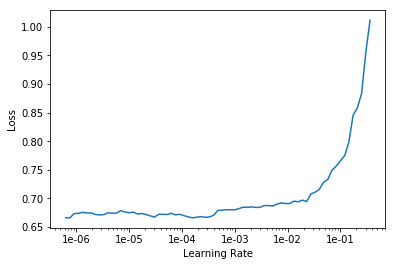

In [47]:
learn.lr_find()
learn.recorder.plot()

In [90]:
print(data.classes)
learn.data.batch_size

['fake', 'real']


32

In [205]:
learn.fit_one_cycle(5, max_lr = slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.560081,0.587431,0.688247
2,0.585592,0.583629,0.691352
3,0.548207,0.576736,0.699952
4,0.526985,0.575528,0.705208
5,0.544158,0.572644,0.703058


In [91]:
# data = ImageDataBunch.create_from_ll(src, size = 224, test = 'test', bs = 32, ds_tfms = get_transforms())
# data.path = '/home/ubuntu/Documents/'
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.load('resnet50_trns_iter1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (12560 items)
[Category real, Category real, Category real, Category real, Category real]...
Path: /home/ubuntu/share/stage-3/stage3_image_data
x: ImageItemList (12560 items)
[Image (3, 717, 960), Image (3, 720, 1280), Image (3, 900, 600), Image (3, 750, 499), Image (3, 750, 499)]...
Path: /home/ubuntu/share/stage-3/stage3_image_data;

Valid: LabelList
y: CategoryList (4186 items)
[Category real, Category real, Category real, Category real, Category fake]...
Path: /home/ubuntu/share/stage-3/stage3_image_data
x: ImageItemList (4186 items)
[Image (3, 1024, 729), Image (3, 600, 600), Image (3, 2246, 3369), Image (3, 1026, 900), Image (3, 1200, 1600)]...
Path: /home/ubuntu/share/stage-3/stage3_image_data;

Test: LabelList
y: EmptyLabelList (5430 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (5430 items)
[Image (3, 714, 964), Image (3, 1125, 1500), Image (3, 660, 970), Image

In [92]:
l = learn.get_preds()
l

[tensor([[0.2393, 0.7607],
         [0.1080, 0.8920],
         [0.2749, 0.7251],
         ...,
         [0.3568, 0.6432],
         [0.2401, 0.7599],
         [0.6485, 0.3515]]), tensor([1, 1, 1,  ..., 0, 1, 0])]

In [93]:
a = [float(x[1]) for x in l[0]]

In [94]:
temp = np.argmax(l[0], axis = 1)
temp

tensor([1, 1, 1,  ..., 1, 1, 0])

In [95]:
np.unique(temp, return_counts=True)

(array([0, 1]), array([ 798, 3388]))

In [96]:
get_metrics(data.valid_ds.y.items, temp)

F1_score:  0.474204842480635
Accuracy:  0.524605828953655
[[ 445 1637]
 [ 353 1751]]


In [103]:
# getting test predictions
test_output = learn.get_preds(DatasetType.Test)
test_output

[tensor([[0.0702, 0.9298],
         [0.2291, 0.7709],
         [0.2932, 0.7068],
         ...,
         [0.5602, 0.4398],
         [0.2433, 0.7567],
         [0.3969, 0.6031]]), tensor([0, 0, 0,  ..., 0, 0, 0])]

In [104]:
labels = np.argmax(test_output[0], axis = 1)
np.array(labels)

array([1, 1, 1, 1, ..., 1, 0, 1, 1])

In [105]:
output_df = pd.DataFrame({'Filename':data.test_dl.x.items, 'Prediction': np.array(labels)})

In [106]:
output_df['Filename'] = output_df['Filename'].apply(lambda x: str(x).split('/')[-1])

In [107]:
output_df.head()

,Filename,Prediction
0,3a7458a237d5d457c88ff8ebacb73481.jpg,1
1,63b3f3fd3a255d3ff49ad52ac7f34453.jpg,1
2,65093b60262226d52221d4fa17f614cc.jpg,1
3,9ee7256d99e720cbb653b6a536871307.jpg,1
4,e20d2f9863e74bbd0fdbc4c3e38f092b.jpg,1


In [108]:
output_df['Prediction'] = output_df['Prediction'].map({0: 'fake', 1: 'real'})

In [109]:
output_df.head()

,Filename,Prediction
0,3a7458a237d5d457c88ff8ebacb73481.jpg,real
1,63b3f3fd3a255d3ff49ad52ac7f34453.jpg,real
2,65093b60262226d52221d4fa17f614cc.jpg,real
3,9ee7256d99e720cbb653b6a536871307.jpg,real
4,e20d2f9863e74bbd0fdbc4c3e38f092b.jpg,real


In [110]:
output_df['Prediction'].value_counts()

real    4709
fake     721
Name: Prediction, dtype: int64

In [111]:
output_df.to_csv('submission_only_resnet50.csv', index=False)

In [112]:
test_output[0]

tensor([[0.0702, 0.9298],
        [0.2291, 0.7709],
        [0.2932, 0.7068],
        ...,
        [0.5602, 0.4398],
        [0.2433, 0.7567],
        [0.3969, 0.6031]])

In [113]:
np.argmax(np.array(test_output[0]), axis = 1)

array([1, 1, 1, 1, ..., 1, 0, 1, 1])

In [86]:
def get_data_for_ela():
    path = '/home/ubuntu/Documents/ELA'
    files_df = pd.read_csv('training_data.csv')
    files,labels = list(files_df['Files'].values), list(files_df['labels'].values)
    
    files = ['/home/ubuntu/Documents/ELA/' + '/'.join(x.split('/')[-3:]) for x in files]
    fname2label = {f:l for (f,l) in zip(files, labels)}
    src = ImageItemList(files, path=path).random_split_by_pct(valid_pct=0.25, seed=42).label_from_func(lambda x:fname2label[x])
    
    data = ImageDataBunch.create_from_ll(src, size = 299, test = 'test', bs = 32, ds_tfms = None)
    data.path = '/home/ubuntu/Documents/'
    return data
    

In [83]:
net_dict = {'resnet18': models.resnet18, 'resnet34': models.resnet34, 'resnet50': models.resnet50, 'resnet101': models.resnet101}
models_used_def = ['resnet50_trns_iter_2','resnet34_ela_299_iter22']
def get_ensemble(models_used = models_used_def, is_test = False):
    models_combined = pd.DataFrame()
    all_res = {}
    for i in models_used:
        print(i)
        netname = i.split('_')[0]
        arch = net_dict[netname]
        if('ela' in i):
            # need to load data from ela folder
            print('its ela')
            data_ela = get_data_for_ela()
            learn = create_cnn(data_ela, arch, metrics=accuracy)
            learn.load(i)
        else:
            learn = create_cnn(data, arch, metrics=accuracy)
            learn.load(i)
        if(is_test):
            d = DatasetType.Test
        else:
            d = DatasetType.Valid
        probs = learn.get_preds(d)
        all_res[i] = np.argmax(probs[0], axis = 1)
        all_res[i+'fake'] = [float(x[0]) for x in probs[0]]
        all_res[i+'real'] = [float(x[1]) for x in probs[0]]
        if(is_test == False):
            get_metrics(data.valid_ds.y.items, all_res[i])
        all_res[i+'|prob'] = np.max(np.array(probs[0]), axis = 1)
    models_combined = pd.DataFrame(all_res)
    return models_combined

def get_ensemble_submission(is_t = False):
    results_combined = get_ensemble(is_test = is_t)
    results_combined['confident'] = results_combined[[x+'|prob' for x in models_used_def]].idxmax(axis = 1)
    results_combined['label'] = results_combined.apply(lambda x : x[x['confident'].split('|')[0]], axis = 1)
    return results_combined['label'].astype(int).values

def get_submission_file(learn, ensemble = True, output_filename = 'final_submission.csv'):
    if(ensemble):
        test_preds = get_ensemble_submission(True)
    else:
        test_predictions = learn.predict(is_test = True)
        test_preds = np.argmax(test_predictions, axis=1)  # from log probabilities to 0 or 1ts
        test_probs = np.exp(test_predictions[:,1])        # pr()
        
    labels = [data.classes[x] for x in test_preds]
    assert(len(data.test_dl.x.items) == len(labels))
    
    output_df = pd.DataFrame({'Filename':data.test_dl.x.items, 'Prediction': np.array(labels)})
    output_df['Filename'] = output_df['Filename'].apply(lambda x: str(x).split('/')[-1])
    
    output_df.to_csv(output_filename, index=False)
    return output_df



In [87]:
dela = get_data_for_ela()
len(dela.test_ds.y.items)

5430

In [60]:
comb = get_ensemble(is_test = False)

F1_score:  0.7995151962610598
Accuracy:  0.8000477783086479
[[1561  521]
 [ 316 1788]]


In [88]:
comb = get_ensemble(is_test = True)

In [89]:
comb['confident'] = comb[[x+'|prob' for x in models_used_def]].idxmax(axis = 1)

In [90]:
comb['label'] = comb.apply(lambda x : x[x['confident'].split('|')[0]], axis = 1)

In [93]:
la = comb['label'].astype(int).values
lals = [data.classes[x] for x in la]
assert(len(data.test_dl.x.items) == len(lals))

output_df = pd.DataFrame({'Filename':data.test_dl.x.items, 'Prediction': np.array(lals)})
output_df['Filename'] = output_df['Filename'].apply(lambda x: str(x).split('/')[-1])

output_df.to_csv('submission_ela_ens', index=False)

In [95]:
output_df.Prediction.value_counts()

real    2800
fake    2630
Name: Prediction, dtype: int64

In [63]:
comb.head()

,resnet50_trns_iter_2,resnet50_trns_iter_2fake,resnet50_trns_iter_2real,resnet50_trns_iter_2|prob,resnet34_ela_299_iter22,resnet34_ela_299_iter22fake,resnet34_ela_299_iter22real,resnet34_ela_299_iter22|prob,confident,label
0,1,0.055228,0.944772,0.944772,1,0.416043,0.583957,0.583957,resnet50_trns_iter_2|prob,1
1,1,0.206869,0.793131,0.793131,1,0.497745,0.502255,0.502255,resnet50_trns_iter_2|prob,1
2,1,0.318592,0.681408,0.681408,1,0.322339,0.677661,0.677661,resnet50_trns_iter_2|prob,1
3,0,0.656912,0.343088,0.656912,1,0.429506,0.570494,0.570494,resnet50_trns_iter_2|prob,0
4,0,0.753644,0.246356,0.753644,1,0.450236,0.549764,0.549764,resnet50_trns_iter_2|prob,0


In [64]:
get_metrics(data.valid_ds.y.items, comb.label.values)

F1_score:  0.8282291803995502
Accuracy:  0.8284758719541329
[[1649  433]
 [ 285 1819]]


In [55]:
comb['average_fake'] = (comb['resnet50_trns_iter_2fake'] + comb['resnet34_ela_299_iter22fake']) / 2.0
comb['average_real'] = (comb['resnet50_trns_iter_2real'] + comb['resnet34_ela_299_iter22real']) / 2.0

In [57]:
comb.head()

,resnet50_trns_iter_2,resnet50_trns_iter_2fake,resnet50_trns_iter_2real,resnet50_trns_iter_2|prob,resnet34_ela_299_iter22,resnet34_ela_299_iter22fake,resnet34_ela_299_iter22real,resnet34_ela_299_iter22|prob,confident,label,average_fake,average_real,label_avg
0,1,0.055228,0.944772,0.944772,1,0.416043,0.583957,0.583957,resnet50_trns_iter_2|prob,1,0.235636,0.764364,1
1,1,0.206869,0.793131,0.793131,1,0.497745,0.502255,0.502255,resnet50_trns_iter_2|prob,1,0.352307,0.647693,1
2,1,0.318592,0.681408,0.681408,1,0.322339,0.677661,0.677661,resnet50_trns_iter_2|prob,1,0.320466,0.679534,1
3,0,0.656912,0.343088,0.656912,1,0.429506,0.570494,0.570494,resnet50_trns_iter_2|prob,0,0.543209,0.456791,0
4,0,0.753644,0.246356,0.753644,1,0.450236,0.549764,0.549764,resnet50_trns_iter_2|prob,0,0.601940,0.398060,0


In [56]:
comb['label_avg'] = comb[['average_fake','average_real']].idxmax(axis = 1)
comb['label_avg'] = comb['label_avg'].map({'average_fake':0, 'average_real':1})
get_metrics(data.valid_ds.y.items, comb.label_avg.values)

F1_score:  0.8282291803995502
Accuracy:  0.8284758719541329
[[1649  433]
 [ 285 1819]]


In [58]:
comb.to_csv('first_cut_res.csv')

In [ ]:

model_combined['confident'] = model_combined[[x+'|prob' for x in models_used_i]].idxmax(axis = 1)

boo = model_combined[models_used_i].mode(axis=1)
boonull = boo.isnull()
for i,row in model_combined.iterrows():
    if(boonull.loc[i,1]):
        model_combined.loc[i,'label'] = boo.loc[i,0]
    else:
        model_combined.loc[i,'label'] = row[row['confident'].split('|')[0]]

model_combined['label'] = model_combined.apply(lambda x : x[x['confident'].split('|')[0]], axis = 1)
# model_combined['label'] = model_combined.apply(lambda x : x['resnet101_2_steps'] if (x['resnet101_2_stepsprob'] > x['resnet50_3_stepsprob']) else x['resnet50_3_steps'], axis = 1)
model_combined['actuals_y'] = data.val_y
model_combined['actual_labels'] = model_combined.apply(lambda x : data.classes[int(x['actuals_y'])], axis = 1)
model_combined['predicted_labels'] = model_combined.apply(lambda x : data.classes[int(x['label'])], axis = 1)
print(accuracy_score(model_combined.actual_labels.values, model_combined.predicted_labels.values))

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(model_combined.label.values, learn.data.val_y)
print(accuracy_score(model_combined.label.values, learn.data.val_y))
print(cm)

model_combined.to_csv('result_temp.csv')

testr = get_submission_file(learn, ensemble = True)

testr[testr['image_id'] == 'ffd889f4b3138459e1203a4190286158a9aaea40.jpg']

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
# Try other models as well from pretrained batch - better than resnet ones
# Try their transformation variants
# Progressive resizing of the best model till now

In [ ]:
# Train individual networks with progressively increasing image sizes
# Incrementally train larger networks with more image size and smaller batch size